In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
import warnings
%matplotlib inline
import pickle
import re
import string
import time
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn.svm import OneClassSVM
from nltk import SnowballStemmer
from nltk.corpus import stopwords
from sklearn.ensemble import AdaBoostClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.preprocessing import LabelEncoder
from sklearn import svm
from sklearn.utils import shuffle
from tensorflow.keras import Sequential
from tensorflow.keras import layers, callbacks
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

warnings.filterwarnings('ignore')

In [14]:
df2 = pd.read_csv('final_twitter_dataset.csv')
df2.head()

,Unnamed: 0,cleaned_text,emotion
0,0,fuckin m transtelecom,anger
1,1,working but it s fridaaaayyyyy,anger
2,2,packing i don t like it,anger
3,3,i tried to dye my hair and all i got was a blo...,anger
4,4,quot locked up abroad quot makes bein half bro...,anger


In [15]:
encoder = LabelEncoder()
df2['Label'] = encoder.fit_transform(df2['emotion'])
df2.head()

,Unnamed: 0,cleaned_text,emotion,Label
0,0,fuckin m transtelecom,anger,0
1,1,working but it s fridaaaayyyyy,anger,0
2,2,packing i don t like it,anger,0
3,3,i tried to dye my hair and all i got was a blo...,anger,0
4,4,quot locked up abroad quot makes bein half bro...,anger,0


In [16]:
import matplotlib.pyplot as plt

# Set parameters for decoration of plots
params = {'legend.fontsize' : 'large',
          'figure.figsize'  : (15,10),
          'axes.labelsize'  : 'x-large',
          'axes.titlesize'  :'x-large',
          'xtick.labelsize' :'large',
          'ytick.labelsize' :'large',
         }

CMAP = plt.cm.brg

plt.rcParams.update(params)

def fn_plot_hist(hist_df):
    
    fig, axes = plt.subplots(1,2 , figsize = (15,6))

    # properties  matplotlib.patch.Patch 
    props = dict(boxstyle='round', facecolor='aqua', alpha=0.4)

    ax = axes[0]

    hist_df.plot(y = [hist_df.columns[0],hist_df.columns[2]], ax = ax, colormap=CMAP)

    lossmin = hist_df[hist_df.columns[0]].min()

    testmin = hist_df[hist_df.columns[2]].min()

    # little beautification
    txtstr = "Min {}: \n Training : {:7.4f}\n Testing   : {:7.4f}".format(hist_df.columns[0],
                                                                          lossmin,
                                                                          testmin) #text to plot

    # place a text box in upper left in axes coords

    ax.text(0.4, 0.95, txtstr, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)

    ax.set_xlabel("Epochs")

    ax.set_ylabel(hist_df.columns[0].capitalize())

    ax.grid();

    ax = axes[1]

    hist_df.plot( y = [hist_df.columns[1], hist_df.columns[3]], ax = ax, colormap=CMAP)

    # little beautification
    accmin = hist_df[hist_df.columns[1]].max()
    testmin = hist_df[hist_df.columns[3]].max()
    txtstr = "Max {}: \n Training : {:7.4f}\n Testing   : {:7.4f}".format(hist_df.columns[1],
                                                                                accmin,
                                                                                testmin) #text to plot

    # place a text box in upper left in axes coords

    ax.text(0.4, 0.5, txtstr, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)

    ax.set_xlabel("Epochs")
    ax.set_ylabel(hist_df.columns[1].capitalize())
    ax.grid();
    plt.tight_layout()

In [17]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [18]:
def cleaning_text(cleaned_text):
    cleaned_text = cleaned_text.lower()
    cleaned_text = re.sub('r<.*?>', ' ', cleaned_text)
    cleaned_text = re.sub(r'#\w+', ' ', cleaned_text)
    cleaned_text = re.sub(r'@\w+', ' ', cleaned_text)
    cleaned_text = re.sub(r'\d+', ' ', cleaned_text)
    cleaned_text = re.sub(r'http\S+', " ", cleaned_text)

    cleaned_text = cleaned_text.split()
    stop_words = stopwords.words("english")
    cleaned_text = " ".join([word for word in cleaned_text if not word in stop_words])

    for punctuation in string.punctuation:
        cleaned_text = cleaned_text.replace(punctuation, "")

    return cleaned_text


df2['cleaned_text'] = df2['cleaned_text'].apply(lambda x: cleaning_text(x))

In [19]:
df2.shape

(113263, 4)

In [20]:
# individual words considered as tokens
tokenized_tweet = df2['cleaned_text'].apply(lambda x: x.split())
tokenized_tweet.head()

0                               [fuckin, transtelecom]
1                             [working, fridaaaayyyyy]
2                                      [packing, like]
3    [tried, dye, hair, got, blond, chunk, front, m...
4    [quot, locked, abroad, quot, makes, bein, half...
Name: cleaned_text, dtype: object

In [21]:
# stem the words
from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()

tokenized_tweet = tokenized_tweet.apply(lambda sentence: [stemmer.stem(word) for word in sentence])
tokenized_tweet.head()

0                               [fuckin, transtelecom]
1                                [work, fridaaaayyyyy]
2                                         [pack, like]
3    [tri, dye, hair, got, blond, chunk, front, mid...
4    [quot, lock, abroad, quot, make, bein, half, b...
Name: cleaned_text, dtype: object

In [22]:
import pickle
import re
import string
import time
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn.svm import OneClassSVM
from nltk import SnowballStemmer
from nltk.corpus import stopwords
from sklearn.ensemble import AdaBoostClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.preprocessing import LabelEncoder
from sklearn import svm
from sklearn.utils import shuffle
from tensorflow.keras import Sequential
from tensorflow.keras import layers, callbacks
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

In [23]:
# Dictionary length
num_classes = df2.Label.nunique()
res = Counter()
df2['cleaned_text'].str.split().apply(res.update)
dim_dic = len(res.keys())

# Maximum sentence length
max_len_words = max(list(df2['cleaned_text'].apply(len)))

In [24]:
cv = CountVectorizer(ngram_range=(1, 2))
cv_texts = cv.fit_transform(df2.cleaned_text)
X_train, X_val, y_train, y_val = train_test_split(cv_texts, df2.Label,
                                                  test_size=.2, shuffle=True,
                                                  stratify=df2.Label, random_state=3)


In [25]:
tokenizer = Tokenizer(num_words=dim_dic)
tokenizer.fit_on_texts(df2.cleaned_text)

def tokenize_split(x_train, y_train):
    X_train, X_val, y_train, y_val = train_test_split(x_train, y_train,
                                                      test_size=0.10, shuffle=True,
                                                      stratify=y_train, random_state=42)

    train_sequences = tokenizer.texts_to_sequences(X_train)
    train_padded = pad_sequences(train_sequences,
                                 maxlen=max_len_words,
                                 truncating='post',
                                 padding='post')

    val_sequences = tokenizer.texts_to_sequences(X_val)
    val_padded = pad_sequences(val_sequences,
                               maxlen=max_len_words,
                               truncating='post',
                               padding='post', )

    return train_padded, val_padded, y_train, y_val


X_train, X_val, y_train, y_val = tokenize_split(df2.cleaned_text, df2.Label)

In [26]:
model = Sequential([
    layers.Embedding(dim_dic, 100, input_length=max_len_words),
    layers.Bidirectional(layers.LSTM(64, return_sequences=True, recurrent_dropout=0)),
    layers.GlobalAveragePooling1D(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(num_classes, activation='softmax')
])

In [27]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 307, 100)          5045800   
                                                                 
 bidirectional (Bidirectiona  (None, 307, 128)         84480     
 l)                                                              
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                6

In [28]:
start = time.perf_counter()
#early_stopping = callbacks.EarlyStopping(monitor="val_loss",
                                         #mode="min", patience=3)

history = model.fit(X_train, y_train,
                    epochs=20,
                    validation_data=(X_val, y_val),
                    #callbacks=[early_stopping],
                    shuffle=True)

elapsed = time.perf_counter() - start
print('Elapsed %.3f seconds.' % elapsed)

Epoch 1/20
3186/3186 [==============================] - 90s 26ms/step - loss: 1.6893 - accuracy: 0.3933 - val_loss: 1.2469 - val_accuracy: 0.5701
Epoch 2/20
3186/3186 [==============================] - 81s 25ms/step - loss: 1.1048 - accuracy: 0.6246 - val_loss: 1.0617 - val_accuracy: 0.6481
Epoch 3/20
3186/3186 [==============================] - 82s 26ms/step - loss: 0.8640 - accuracy: 0.7165 - val_loss: 1.0195 - val_accuracy: 0.6731
Epoch 4/20
3186/3186 [==============================] - 81s 25ms/step - loss: 0.7161 - accuracy: 0.7671 - val_loss: 1.0086 - val_accuracy: 0.6846
Epoch 5/20
3186/3186 [==============================] - 82s 26ms/step - loss: 0.6184 - accuracy: 0.7995 - val_loss: 1.0379 - val_accuracy: 0.7003
Epoch 6/20
3186/3186 [==============================] - 82s 26ms/step - loss: 0.5523 - accuracy: 0.8188 - val_loss: 1.0681 - val_accuracy: 0.6952
Epoch 7/20
3186/3186 [==============================] - 81s 25ms/step - loss: 0.5058 - accuracy: 0.8324 - val_loss: 1.1066 -

In [29]:
#Convert history to pandas dataframe
res_df = pd.DataFrame(history.history)
res_df

,loss,accuracy,val_loss,val_accuracy
0,1.689335,0.393335,1.246902,0.570054
1,1.104838,0.624578,1.061699,0.648097
2,0.864004,0.716469,1.019545,0.673082
3,0.716061,0.767060,1.008593,0.684647
4,0.618369,0.799511,1.037908,0.700274
5,0.552258,0.818759,1.068136,0.695153
6,0.505752,0.832434,1.106608,0.704158
7,0.471771,0.843824,1.177174,0.709897
8,0.445096,0.851240,1.191791,0.709279
9,0.426597,0.856528,1.146888,0.710073


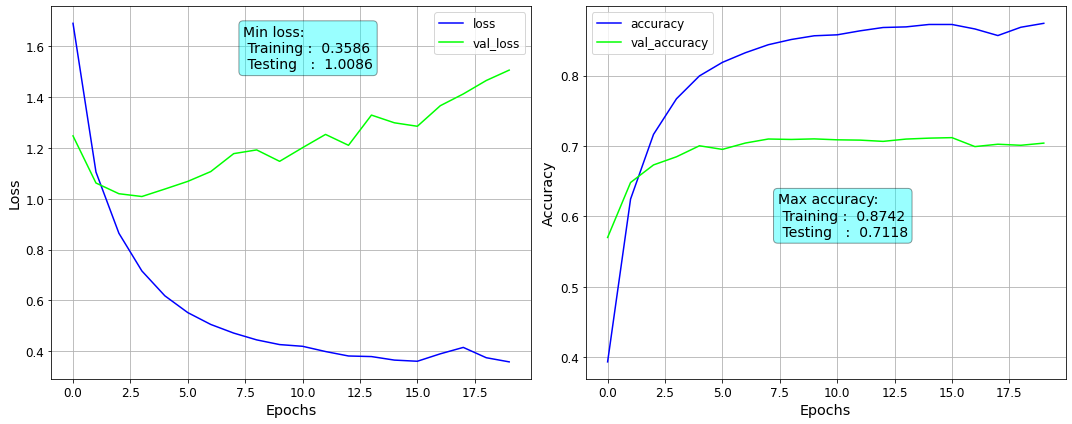

In [30]:
# Plot loss and accuracy curves for both testing and training
fn_plot_hist(res_df)

In [33]:
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import accuracy_score

In [32]:
val_pred = model(X_val)
val_pred = np.argmax(model.predict(X_val), axis=-1)

In [34]:
print("classification_report")
print(classification_report(y_val,val_pred))
print("confusion")
print(confusion_matrix(y_val,val_pred))

classification_report
              precision    recall  f1-score   support

           0       0.66      0.66      0.66      1483
           1       0.72      0.79      0.75      2504
           2       0.76      0.74      0.75       883
           3       0.84      0.79      0.82      1487
           4       0.72      0.64      0.68      1020
           5       0.59      0.64      0.62       630
           6       0.80      0.74      0.77      1058
           7       0.56      0.56      0.56       900
           8       0.60      0.61      0.60       852
           9       0.65      0.61      0.63       510

    accuracy                           0.70     11327
   macro avg       0.69      0.68      0.68     11327
weighted avg       0.71      0.70      0.70     11327

confusion
[[ 982  266   49   26   17   14   23   42   54   10]
 [ 189 1979   55   29   10   30    9  138   53   12]
 [  41   72  651    2    6   24    6   48   26    7]
 [  67   60   14 1181    4    4  122   21    6    